In [35]:
import os
import time
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from models import *
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from numpy import linalg as LA
import numpy as np

torch.manual_seed(0)
device = 'cuda'

In [44]:
num_inputs = 1
num_outputs = 1
num_examples_train = 10000
num_examples_test = 5000
dtype = torch.float

def real_fn(X):
    return 2 * X + 4.2
    #return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2

X_p = torch.load('data_p_linear.pt')
y_p = torch.load('target_p_linear.pt')
# define training set
X_train = torch.randn(num_examples_train, num_inputs, device=device, dtype=dtype)
noise_train = .1 * torch.randn(num_examples_train, num_inputs, device=device, dtype=dtype)
y_train = (real_fn(X_train) + noise_train)


X = torch.cat((X_train,X_p),0)
y = torch.cat((y_train,y_p),0)

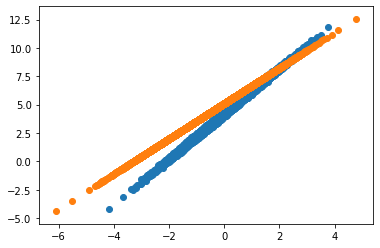

In [45]:
from matplotlib import pyplot as plt
import numpy

plt.scatter(X_train.cpu().numpy(), y_train.cpu().numpy())
plt.scatter(X_p.detach().cpu().numpy(), y_p.detach().cpu().numpy())
#plt.scatter(X.detach().cpu().numpy(), y.detach().cpu().numpy())
plt.show()




In [46]:
class LinearDataset(Dataset):
    def __init__(self, X, y):
        assert X.size()[0] == y.size()[0]
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.size()[0]
    
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [47]:
batch_size = 4
#train_data = DataLoader(LinearDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
train_data = DataLoader(LinearDataset(X, y), batch_size=batch_size, shuffle=False)
#test_data = DataLoader(LinearDataset(X_test, y_test), batch_size=batch_size, shuffle=True)

In [48]:
class LinearRegression(nn.Module):
    def __init__(self, **kwargs):
        super(LinearRegression, self).__init__(**kwargs)
        self.fc1 = nn.Linear(1, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        return x
    
net = LinearRegression()
net.to(device)

LinearRegression(
  (fc1): Linear(in_features=1, out_features=1, bias=True)
)

Epoch 0, loss: 3.956685381048918
Epoch 1, loss: 0.7759239064146299
Epoch 2, loss: 0.24003542043124326
Epoch 3, loss: 0.15581298382147216
Epoch 4, loss: 0.14525099303273017
Epoch 5, loss: 0.14518435050286352
Epoch 6, loss: 0.14592867778735236
Epoch 7, loss: 0.14637606546580792
Epoch 8, loss: 0.14658769681304692
Epoch 9, loss: 0.14668119242107497


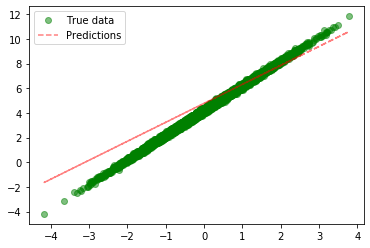

In [49]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=0.9)
epochs = 10
num_batches = num_examples_train/ batch_size
losses = []

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        data = data.to(device)
        label = label.to(device)
        
        yhat = net(data)
        loss = loss_fn(yhat, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cumulative_loss += loss.item()
    print("Epoch %s, loss: %s" % (e, cumulative_loss / num_examples_train))
    losses.append(cumulative_loss / num_batches)
plt.clf()
plt.plot(X_train.cpu().numpy(), y_train.cpu().numpy(), 'go', label='True data', alpha=0.5)
plt.plot(X_train.cpu().numpy(), net(X_train).detach().cpu().numpy(), '--', color ='red', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()

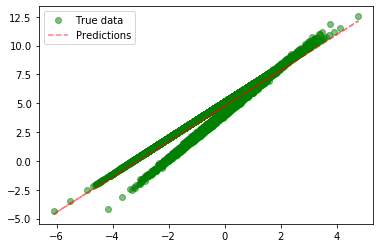

In [50]:
plt.clf()
plt.plot(X.detach().cpu().numpy(), y.detach().cpu().numpy(), 'go', label='True data', alpha=0.5)
plt.plot(X.detach().cpu().numpy(), net(X).detach().cpu().numpy(), '--', color ='red', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()